In [81]:
"""Figure core creation: Fig3

Formatting of the figures may not be identical to the paper, but they contain the same data points.
"""
# pylint: disable=import-error, redefined-outer-name, use-dict-literal, too-many-lines, too-many-branches, consider-using-f-string

'Figure core creation: Fig3\n\nFormatting of the figures may not be identical to the paper, but they contain the same data points.\n'

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [ ]:
from __future__ import annotations

import re
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display

from epi_ml.utils.notebooks.paper.paper_utilities import (
    ASSAY,
    ASSAY_MERGE_DICT,
    CELL_TYPE,
    SEX,
    IHECColorMap,
    MetadataHandler,
    SplitResultsHandler,
)

### General paths setup

In [84]:
base_dir = Path.home() / "Projects/epiclass/output/paper"
paper_dir = base_dir
if not paper_dir.exists():
    raise FileNotFoundError(f"Directory {paper_dir} does not exist.")

base_data_dir = base_dir / "data"
base_fig_dir = base_dir / "figures"

In [85]:
IHECColorMap = IHECColorMap(base_fig_dir)
assay_colors = IHECColorMap.assay_color_map
cell_type_colors = IHECColorMap.cell_type_color_map
sex_colors = IHECColorMap.sex_color_map

In [86]:
split_results_handler = SplitResultsHandler()

metadata_handler = MetadataHandler(paper_dir)
metadata_v2 = metadata_handler.load_metadata("v2")
metadata_v2_df = metadata_handler.load_metadata_df("v2")

### ChIP-Atlas predictions file `CA_metadata_4DB+all_pred.20240606_mod3.0.tsv`

See README for meaning of mod3.0.

In [87]:
base_pred_dir = base_data_dir / "training_results" / "predictions"
if not base_pred_dir.exists():
    raise FileNotFoundError(f"Directory {base_pred_dir} does not exist.")

ca_preds_dir = base_pred_dir / "C-A"
ca_preds_path = ca_preds_dir / ASSAY / "CA_metadata_4DB+all_pred.20240606_mod3.0.tsv"
ca_preds_df = pd.read_csv(ca_preds_path, sep="\t", low_memory=False)

print(f"ChIP-Atlas: {ca_preds_df.shape[0]} total files")
# TODO: have clear encode metadata file specified in markdown, so 13c content is explicit

ChIP-Atlas: 48669 total files


In [88]:
DB_COLS = ["GEO_mod", "C-A", "Cistrome", "NGS_mod"]

In [89]:
print("ChIP-Atlas - Available model predictions")
for col in ca_preds_df.columns:
    if "Max_pred" in col:
        model_task = col.split("_")[-1]
        print(model_task)

ChIP-Atlas - Available model predictions
assay7
assay11
assay13
cancer
disease
donorlife
project
sex
assay
biomat
paired
sex.1
disease.1


In [90]:
if ca_preds_df[ca_preds_df.isin(["h3.3k27m"])].notna().sum().sum() != 0:
    raise ValueError("h3.3k27m is still present in the dataframe")

Predictions from following models and more:
| Metadata category|   Nb classes |     Experiment Key (comet.com)      | Nb Files | Training Size |
|------------------|--------------|------------------------------|----------|---------------|
| assay_epiclass   |     7      | 69488630801b4a05a53b5d9e572f0aaa       | 16788    | 34413 |
| assay_epiclass   |     11      | 0f8e5eb996114868a17057bebe64f87c      | 20922    | 46128 |
| assay_epiclass   |     13      | dd3710b73c0341af85a17ce1998362d0      | 24989    | 116550|
| harmonized_donor_sex | 3    | 4b908b83e0ec45c3ab991e65aa27af0c | 18299    | 28078  |
| harmonized_donor_life_stage | 5    | 91214ed0b1664395b1826dc69a495ed4 | 15372    | 66372  |
| harmonized_sample_cancer_high | 2    | 15da476b92f140eab818ece369248f4c | 20922    | 34491  |

The training size is higher than the number of files because of random oversampling of minority classes up to approx. majority size.

Classes:

- assay 7c: 6 h3k* histone marks + input
- assay 11c: assay7c + rna_seq + mrna_seq + wgbs_standard + wgbs_pbat
- assay 13c: assay11c + encode non-core + encode CTCF
- harmonized_donor_sex: male, female, mixed
- harmonized_donor_life_stage: adult, child, newborn, fetal, embryonic
- harmonized_sample_cancer_high (modification of harmonized_sample_disease_high): cancer, non-cancer (healthy/None+disease)

Training metadata: `IHEC_metadata_harmonization.v1.1.extended.csv` + encode XXXX

### ENCODE predictions file `encode_predictions_augmented_merged.csv`

See `model.list` in `encode_preds_dir`.  
Same models as ChIP-Atlas predictions. The assay_epiclass model is the 7c one.  
Additonally, the `harmonized_sample_ontology_intermediate` model was used on a subset of files with known EpiATLAS sample ontologies.

| Metadata category|   Nb classes |     Experiment Key (comet.com)      | Nb Files | Training Size |
|------------------|--------------|------------------------------|----------|---------------|
| harmonized_sample_ontology_intermediate   |     16      | bb66b72ae83645d587e50b34aebb39c3      | 16379    | 49054|


In [91]:
encode_preds_dir = base_pred_dir / "encode"
encode_preds_path = encode_preds_dir / "encode_predictions_augmented_merged.csv"
encode_preds_df = pd.read_csv(encode_preds_path, sep="\t", low_memory=False)
print(f"ENCODE: {encode_preds_df.shape[0]} total files")

ENCODE: 9619 total files


## Fig 3

Removing ChIP-Atlas experiment overlap with EpiATLAS

In [92]:
print(f"ChIP-Atlas: Initial {ca_preds_df.shape[0]} files")
no_epiatlas_df = ca_preds_df[ca_preds_df["is_EpiAtlas_EpiRR"] == "0"]

diff = ca_preds_df.shape[0] - no_epiatlas_df.shape[0]
print(f"ChIP-Atlas: {diff} files with EpiAtlas EpiRR removed")
print(f"ChIP-Atlas: {no_epiatlas_df.shape[0]} files without EpiAtlas EpiRR")

ChIP-Atlas: Initial 48669 files
ChIP-Atlas: 1047 files with EpiAtlas EpiRR removed
ChIP-Atlas: 47622 files without EpiAtlas EpiRR


Ignoring non-core consensus files.

In [93]:
non_core_labels = ["non-core", "CTCF"]
ca_core7_df = no_epiatlas_df[
    ~no_epiatlas_df["manual_target_consensus"].isin((non_core_labels))
]

diff = no_epiatlas_df.shape[0] - ca_core7_df.shape[0]
print(f"ChIP-Atlas: {diff} files with non-core consensus removed")
print(f"ChIP-Atlas: {ca_core7_df.shape[0]} files with core consensus")

ChIP-Atlas: 918 files with non-core consensus removed
ChIP-Atlas: 46704 files with core consensus


In [94]:
ca_core7_df["manual_target_consensus"].value_counts()

input           17930
h3k27ac         11169
h3k4me3          6328
h3k27me3         4195
h3k4me1          3034
h3k9me3          2102
h3k36me3         1421
no_consensus      525
Name: manual_target_consensus, dtype: int64

### Fig 3A - ChIP-Atlas assay (7classes) prediction

#### High-confidence predictions

In [95]:
total_N = ca_core7_df.shape[0]
high_confidence_pred_df = ca_core7_df[ca_core7_df["Max_pred_assay7"] >= 0.6]

high_confidence_N = high_confidence_pred_df.shape[0]
N_percent = high_confidence_N / total_N
display(
    f"ChIP-Atlas: {high_confidence_N}/{total_N} files ({high_confidence_N/total_N:.2%}) with high confidence assay prediction"
)

'ChIP-Atlas: 41796/46704 files (89.49%) with high confidence assay prediction'

#### Match between manual target consensus and MLP prediction

In [96]:
total_N = high_confidence_pred_df.shape[0]

match_rule = (
    high_confidence_pred_df["manual_target_consensus"]
    == high_confidence_pred_df["Predicted_class_assay7"]
)
match_df = high_confidence_pred_df[match_rule]
mismatch_df = high_confidence_pred_df[~match_rule]

agreement_N = match_df.shape[0]

print(
    f"ChIP-Atlas: {agreement_N}/{total_N} files ({agreement_N / total_N:.2%}) with agreement between consensus and predicted assay"
)

ChIP-Atlas: 39532/41796 files (94.58%) with agreement between consensus and predicted assay


#### Mismatch breakdown

In [97]:
total_mismatch = mismatch_df.shape[0]
input_rule = mismatch_df["Predicted_class_assay7"] == "input"
input_pred_N = input_rule.sum()

print(
    f"ChIP-Atlas: {input_pred_N}/{total_mismatch} files ({input_pred_N / total_mismatch:.2%}) with mismatch predicted as input"
)
print(
    f"ChIP-Atlas: {total_mismatch-input_pred_N}/{total_mismatch} files ({(total_mismatch-input_pred_N) / total_mismatch:.2%}) potential mislabels"
)
display(mismatch_df[~input_rule]["core7_DBs_consensus"].value_counts(dropna=False))

ChIP-Atlas: 1525/2264 files (67.36%) with mismatch predicted as input
ChIP-Atlas: 739/2264 files (32.64%) potential mislabels


Identical                       468
Different                       158
Ignored - Potential non-core     64
1 source                         49
Name: core7_DBs_consensus, dtype: int64

### Fig 3B-C-D - ChIP-Atlas donor sex, cancer and life stage predictions

In [174]:
new_ca_meta_path = ca_preds_path.parent / "CA_metadata_FW_20240917.tsv"
new_ca_meta_df = pd.read_csv(new_ca_meta_path, sep="\t", low_memory=False)

new_ca_meta_df["True_class_FW_donorlife"] = new_ca_meta_df["True_class_FW_age"]
new_cols = ["True_class_FW_cancer", "True_class_FW_sex", "True_class_FW_donorlife"]
new_ca_meta_df = new_ca_meta_df[["Experimental.id"] + new_cols]

In [175]:
# New life stage label grouping: 3 classes
life_stage_map = {"embryonic": "prenatal", "newborn": "prenatal", "fetal": "prenatal"}
new_ca_meta_df["True_class_FW_donorlife_merged"] = new_ca_meta_df[
    "True_class_FW_donorlife"
].replace(life_stage_map)

ca_preds_df["Predicted_class_donorlife_merged"] = ca_preds_df[
    "Predicted_class_donorlife"
].replace(life_stage_map)
ca_preds_df["Max_pred_donorlife_merged"] = ca_preds_df["Max_pred_donorlife"]

In [176]:
ca_preds_df = ca_preds_df.merge(
    new_ca_meta_df, left_on="Experimental-id", right_on="Experimental.id", how="left"
)

In [177]:
for col in new_cols + ["True_class_FW_donorlife_merged"]:
    print(f"ChIP-Atlas: {col}")
    print(ca_preds_df[col].value_counts(dropna=False), "\n")

ChIP-Atlas: True_class_FW_cancer
NaN           26151
cancer        19802
non-cancer     2716
Name: True_class_FW_cancer, dtype: int64 

ChIP-Atlas: True_class_FW_sex
NaN       40572
male       4158
female     3928
mixed        11
Name: True_class_FW_sex, dtype: int64 

ChIP-Atlas: True_class_FW_donorlife
NaN          40697
adult         5477
newborn       1362
embryonic      620
child          509
fetal            4
Name: True_class_FW_donorlife, dtype: int64 

ChIP-Atlas: True_class_FW_donorlife_merged
NaN         40697
adult        5477
prenatal     1986
child         509
Name: True_class_FW_donorlife_merged, dtype: int64 



In [178]:
def create_summary_table(ca_pred_df: pd.DataFrame) -> pd.DataFrame:
    """Create a summary table for the ChIP-Atlas predictions."""
    results = []
    for cat in ["cancer", "sex", "donorlife", "donorlife_merged"]:
        true_col = f"True_class_FW_{cat}"
        pred_col = f"Predicted_class_{cat}"
        max_pred = f"Max_pred_{cat}"

        # Split data into known and unknown labels
        known_rule = ca_pred_df[true_col].notna()
        known_df = ca_pred_df[known_rule]
        unknown_df = ca_pred_df[~known_rule]

        known_N = known_df.shape[0]
        unknown_N = unknown_df.shape[0]
        total_N = ca_pred_df.shape[0]

        # High confidence calculations for known labels
        high_conf_know_rule = known_df[max_pred] >= 0.6
        high_conf_know_df = known_df[high_conf_know_rule]
        high_conf_know_N = high_conf_know_df.shape[0]
        low_conf_know_N = known_df[~high_conf_know_rule].shape[0]

        # Match calculations
        match_rule = high_conf_know_df[pred_col] == high_conf_know_df[true_col]
        N_match = match_rule.sum()
        N_mismatch = high_conf_know_df.shape[0] - N_match

        # High confidence calculations for unknown labels
        high_conf_unknown_rule = unknown_df[max_pred] >= 0.6
        high_conf_unknown_N = high_conf_unknown_rule.sum()
        low_conf_unknown_N = (~high_conf_unknown_rule).sum()

        # Store results for this category
        results.append(
            {
                "Category": cat,
                "Total Files": total_N,
                "Files with Labels": f"{known_N}/{total_N} ({known_N/total_N:.1%})",
                "High Conf. (with labels)": f"{high_conf_know_N}/{known_N} ({high_conf_know_N/known_N:.1%})",
                "Low Conf. (with labels)": f"{low_conf_know_N}/{known_N} ({low_conf_know_N/known_N:.1%})",
                "Matching Predictions": f"{N_match}/{known_N} ({N_match/known_N:.1%})",
                "Mismatching Predictions": f"{N_mismatch}/{known_N} ({N_mismatch/known_N:.1%})",
                "Files without Labels": f"{unknown_N}/{total_N} ({unknown_N/total_N:.1%})",
                "High Conf. (no labels)": f"{high_conf_unknown_N}/{unknown_N} ({high_conf_unknown_N/unknown_N:.1%})",
                "Low Conf. (no labels)": f"{low_conf_unknown_N}/{unknown_N} ({low_conf_unknown_N/unknown_N:.1%})",
            }
        )

    # Create DataFrame from results
    summary_df = pd.DataFrame(results)

    # Set Category as index for better display
    summary_df.set_index("Category", inplace=True)

    return summary_df

In [180]:
summary_df = create_summary_table(ca_preds_df)

In [ ]:
def create_pie_charts_from_summary(summary_df):
    """Create pie charts from the summary DataFrame."""
    plt.style.use("seaborn")

    def extract_number(value: str) -> int:
        """Extract the first number from strings like '100 (50.0%)'."""
        return int(re.search(r"(\d+)", value).group(1))  # type: ignore

    # Create pie charts for each category
    for category in summary_df.index:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f"Distribution for {category}", fontsize=16, y=1.05)

        # Known Labels Pie Chart
        high_conf_match = extract_number(summary_df.loc[category, "Matching Predictions"])
        high_conf_mismatch = extract_number(
            summary_df.loc[category, "Mismatching Predictions"]
        )
        low_conf_known = extract_number(
            summary_df.loc[category, "Low Conf. (with labels)"]
        )

        known_sizes = [high_conf_match, high_conf_mismatch, low_conf_known]
        total_known = sum(known_sizes)

        known_labels = [
            f"High Conf. Match\n({high_conf_match:,} files, {high_conf_match/total_known:.1%})",
            f"High Conf. Mismatch\n({high_conf_mismatch:,} files, {high_conf_mismatch/total_known:.1%})",
            f"Low Confidence\n({low_conf_known:,} files, {low_conf_known/total_known:.1%})",
        ]
        colors1 = ["#2ecc71", "#e74c3c", "#95a5a6"]  # green, red, gray

        ax1.pie(
            known_sizes,
            labels=known_labels,
            colors=colors1,
            autopct="%1.1f%%",
            startangle=90,
        )
        ax1.set_title("Files with Known Labels", pad=20)

        # Unknown Labels Pie Chart
        high_conf_unknown = extract_number(
            summary_df.loc[category, "High Conf. (no labels)"]
        )
        low_conf_unknown = extract_number(
            summary_df.loc[category, "Low Conf. (no labels)"]
        )

        unknown_sizes = [high_conf_unknown, low_conf_unknown]
        total_unknown = sum(unknown_sizes)

        unknown_labels = [
            f"High Confidence\n({high_conf_unknown:,} files, {high_conf_unknown/total_unknown:.1%})",
            f"Low Confidence\n({low_conf_unknown:,} files, {low_conf_unknown/total_unknown:.1%})",
        ]
        colors2 = ["#3498db", "#95a5a6"]  # blue, gray

        ax2.pie(
            unknown_sizes,
            labels=unknown_labels,
            colors=colors2,
            autopct="%1.1f%%",
            startangle=90,
        )
        ax2.set_title("Files with Unknown Labels", pad=20)

        plt.tight_layout()

    plt.show()

/tmp/ipykernel_70305/3798670803.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


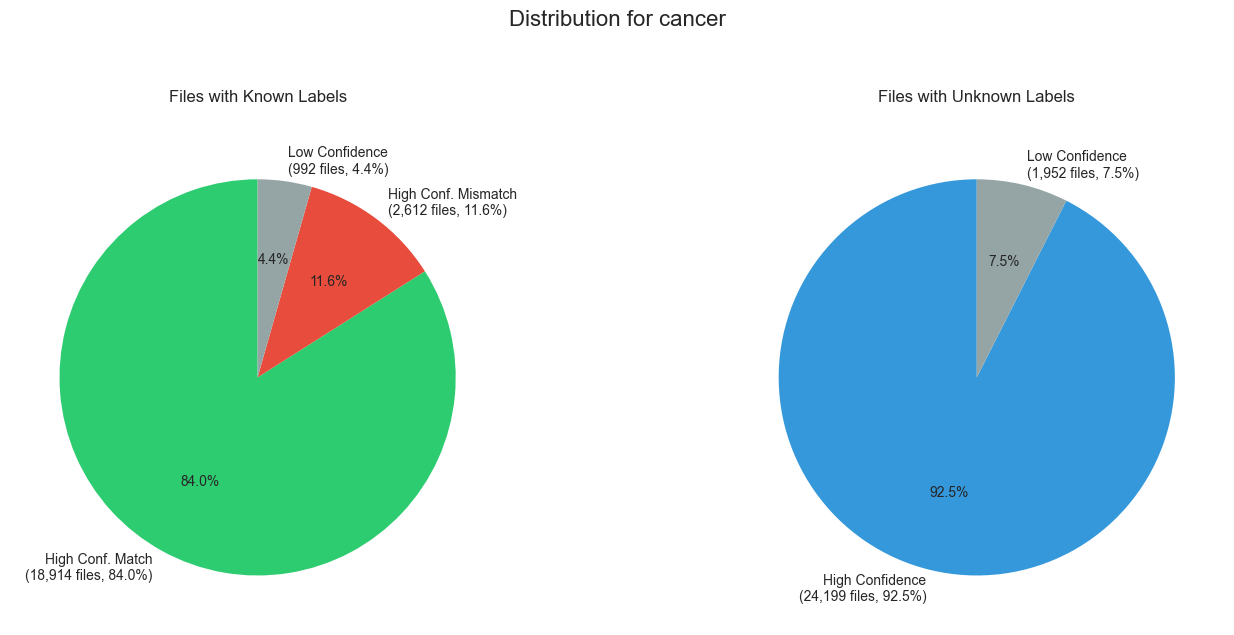

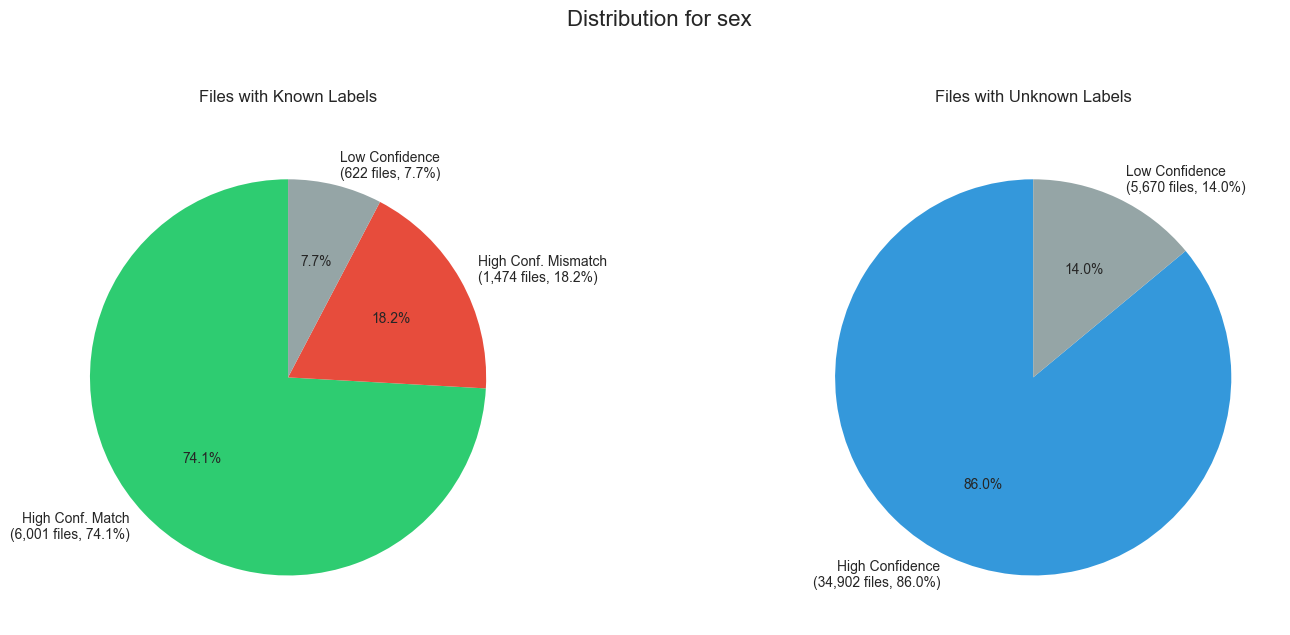

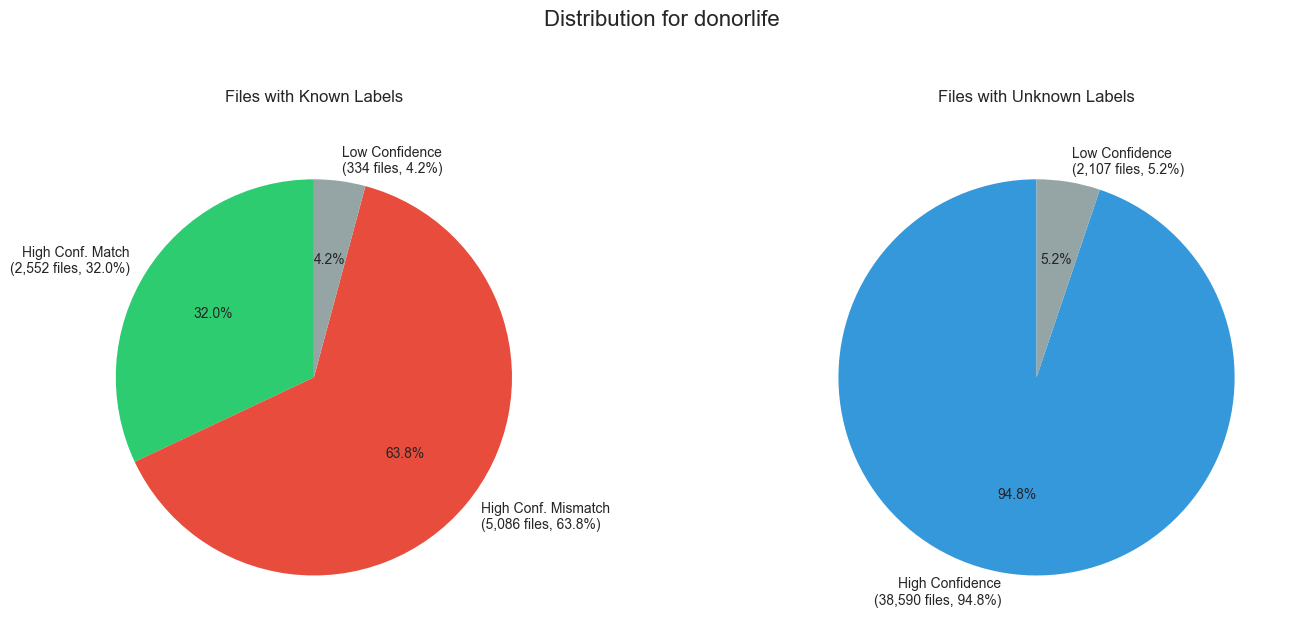

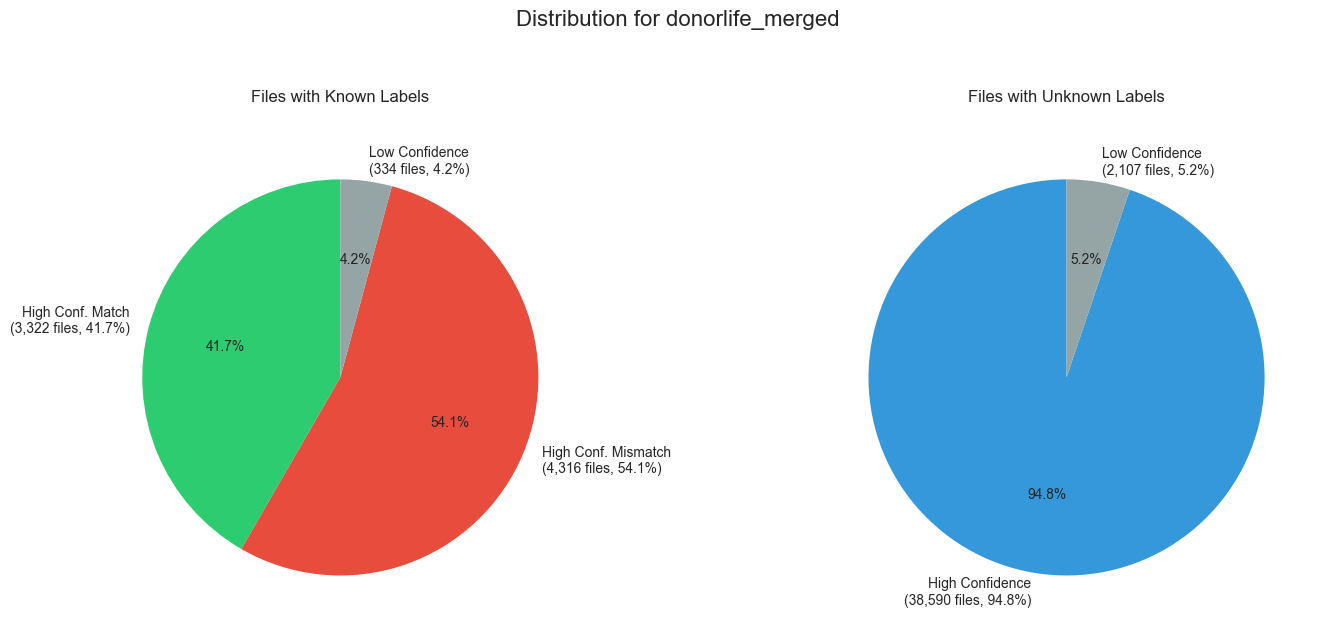

In [182]:
create_pie_charts_from_summary(summary_df)

### Fig 3E - ENCODE dataset predictions (5 tasks)

### Fig 3F - ENCODE non-core predictions with assay category mapping

## Supp Fig 5A